# Vector Quantized Variational Autoencoders (VQ-VAEs)

Rather than computing a continuous latent representation of the input, in VQ-VAEs we compute a discrete latent representation. Here, our encoder output is discretized with respect to a learned discrete set of embeddings we refer to as a codebook.

The goal here is to tackle the smoothing problem noticed in general VAEs, as well as to reduce computational complexity. We can then use the (encoder + codebook) as a tokenizer for different types of transformers.

In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from vision.resnet import ResBlock

In [78]:
device = torch.device("mps")

In [79]:
class VQVAE(nn.Module):
    def __init__(
        self,
        n_channels: int,
        latent_dim: int,
        codebook_size: int,
    ):
        super().__init__()
        
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Conv2d(n_channels, latent_dim, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(latent_dim),
            nn.Conv2d(latent_dim, latent_dim, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(latent_dim),
            nn.Conv2d(latent_dim, latent_dim, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(latent_dim),
            ResBlock(latent_dim, latent_dim, nn.ReLU),
            ResBlock(latent_dim, latent_dim, nn.ReLU),
        )

        self.codebook = nn.Parameter(
            torch.randn(codebook_size, latent_dim) * 0.02, 
            requires_grad=True
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(latent_dim, latent_dim, kernel_size=1),
            ResBlock(latent_dim, latent_dim, nn.ReLU),
            ResBlock(latent_dim, latent_dim, nn.ReLU),
            nn.ConvTranspose2d(latent_dim, latent_dim, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(latent_dim),
            nn.ConvTranspose2d(latent_dim, latent_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(latent_dim),
            nn.ConvTranspose2d(latent_dim, latent_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(latent_dim),
            nn.ConvTranspose2d(latent_dim, n_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the VAE.

        Args:
            x: input data

        Returns:
            x_hat: reconstructed data
        """
        z_encoder = self.encoder(x)
        z_quantized = self._quantize_encoder_output(z_encoder)
        z_q_st = z_encoder + (z_quantized - z_encoder).detach()
        return self.decoder(z_q_st), z_encoder, z_quantized
    
    def _quantize_encoder_output(self, z_e: torch.Tensor) -> torch.Tensor:
        """
        Quantizing the encoded tensor by snapping its elements to the closest codebook 
        entry.

        Args:
            z_e: encoded representation

        Returns:
            z_q: quantized representation
        """
        batch_size, latent_dim, h, w = z_e.shape
        encoded = z_e.permute(0, 2, 3, 1).reshape(batch_size*h*w, latent_dim)
        quantized = self.codebook[torch.argmin(torch.cdist(encoded, self.codebook), dim=1)]
        z_q = quantized.reshape(batch_size, h, w, latent_dim).permute(0, 3, 1, 2)
        return z_q

In [80]:
# Create dummy tensors and model for testing
batch_size = 2
n_channels = 3
height = 64
width = 64
latent_dim = 128
codebook_size = 256

dummy_input = torch.randn(batch_size, n_channels, height, width)

dummy_model = VQVAE(
    latent_dim=latent_dim,
    n_channels=n_channels,
    codebook_size=codebook_size
)

print("Input shape:", dummy_input.shape)
print("Running forward pass...")
x_hat, z_e, z_quantized = dummy_model(dummy_input)
print(f"Output shape: {x_hat.shape}")
print(f"z_e.shape: {z_e.shape}, z_quantized.shape: {z_quantized.shape}")

Input shape: torch.Size([2, 3, 64, 64])
Running forward pass...
Output shape: torch.Size([2, 3, 64, 64])
z_e.shape: torch.Size([2, 128, 8, 8]), z_quantized.shape: torch.Size([2, 128, 8, 8])


## Objective Function

Our objective function consists of 3 terms:

![VQ-VAE Loss Function](images/vq_vae_loss.png)

1. Reconstruction Loss: Ensures the decoded output matches the input
2. Codebook Loss: Keeps the codebook entries close to the encoded representations  
3. Commitment Loss: Prevents the encoder from growing too large


In [81]:
def validate(
    model: nn.Module,
    recon_loss_fn: nn.Module,
    cb_loss_fn: nn.Module,
    commit_loss_fn: nn.Module,
    valid_dl: DataLoader,
    beta: float = 1.
):
    model.eval()
    with torch.no_grad():
        tot_loss = 0.
        tot_recon_loss = 0.
        tot_codebook_loss = 0.
        tot_commit_loss = 0.
        num_batches = 0
        for xb, _ in valid_dl:
            x_hat, z_e, z_quantized = model(xb)
            recon_loss = recon_loss_fn(x_hat, xb)
            codebook_loss = cb_loss_fn(z_quantized, z_e.detach())
            commit_loss = commit_loss_fn(z_e, z_quantized.detach())
            loss = recon_loss + codebook_loss + (beta * commit_loss)
            
            tot_loss += loss.item()
            tot_recon_loss += recon_loss.item()
            tot_codebook_loss += codebook_loss.item()
            tot_commit_loss += commit_loss.item()
            num_batches += 1
    
    tot_loss /= num_batches
    tot_recon_loss /= num_batches
    tot_codebook_loss /= num_batches
    tot_commit_loss /= num_batches

    return tot_loss, tot_recon_loss, tot_codebook_loss, tot_commit_loss

def kl_loss_func(mu, logvar):
    # Clamp logvar for numerical stability
    logvar = torch.clamp(logvar, -10, 10)
    
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_loss / (mu.size(0) * mu.size(1)) # normalize to prevent explosion

def fit(
    epochs: int, 
    model: nn.Module,
    recon_loss_fn: nn.Module,
    cb_loss_fn: nn.Module,
    commit_loss_fn: nn.Module,
    opt: torch.optim.Optimizer, 
    scheduler: torch.optim.lr_scheduler.LRScheduler,
    train_dl: DataLoader, 
    valid_dl: DataLoader,
    beta: float = 1,
    grad_clip: float = 1.0
):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        model.train()
        for xb, _ in train_dl:
            xb = xb.to(device)
            x_hat, z_e, z_quantized = model(xb)
            recon_loss = recon_loss_fn(x_hat, xb)
            codebook_loss = cb_loss_fn(z_quantized, z_e.detach())
            commit_loss = commit_loss_fn(z_e, z_quantized.detach())
            loss = recon_loss + codebook_loss + (beta * commit_loss)
            
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            opt.step()
            scheduler.step()

        total_loss, recon_loss, codebook_loss, commit_loss = validate(
            model, recon_loss_fn, cb_loss_fn, commit_loss_fn, valid_dl, beta
        )
        print(f"val loss: {total_loss:.6f}, recon: {recon_loss:.6f}, codebook: {codebook_loss:.6f}, commit: {commit_loss:.6f}")


In [82]:
import pickle
import numpy as np
import torch


all_batches_data = []
all_batches_labels = []

for i in range(1, 6):
    with open(f'data/cifar-10-batches-py/data_batch_{i}', 'rb') as f:
        dataset_dict = pickle.load(f, encoding='bytes')
        all_batches_data.append(dataset_dict[b'data'])
        all_batches_labels.append(dataset_dict[b'labels'])

stacked_data = np.vstack(all_batches_data)
stacked_labels = np.hstack(all_batches_labels)
data = torch.tensor(stacked_data, dtype=torch.float32).view(-1, 3, 32, 32).to(device) / 255.
labels = torch.tensor(stacked_labels, dtype=torch.long).to(device)

split_idx = int(0.8 * len(data))

x_train, x_valid = data[:split_idx], data[split_idx:]
y_train, y_valid = labels[:split_idx], labels[split_idx:]

class CIFARCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_ds = CIFARCustomDataset(x_train, y_train)
valid_ds = CIFARCustomDataset(x_valid, y_valid)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True)

In [ ]:
model = VQVAE(
    n_channels=3,
    latent_dim=128,
    codebook_size=128,
)

recon_loss_fn = nn.MSELoss()
cb_loss_fn = nn.MSELoss()
commit_loss_fn = nn.MSELoss()
# Reduce learning rate for codebook specifically
opt = torch.optim.AdamW([
    {'params': [p for n, p in model.named_parameters() if 'codebook' not in n], 'lr': 3e-4},
    {'params': [model.codebook], 'lr': 1e-5}  # lower LR for codebook
])

model.to(device)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=100)

fit(100, model, recon_loss_fn, cb_loss_fn, commit_loss_fn, opt, scheduler, train_dl, valid_dl, beta=0.5)

Epoch 1/100
Validation loss: 0.542722
Reconstruction loss: 0.026698
Codebook loss: 0.344016
Commit loss: 0.344016
Epoch 2/100
Validation loss: 0.472351
Reconstruction loss: 0.023686
Codebook loss: 0.299110
Commit loss: 0.299110
Epoch 3/100
Validation loss: 0.654868
Reconstruction loss: 0.023632
Codebook loss: 0.420824
Commit loss: 0.420824
Epoch 4/100
Validation loss: 0.925869
Reconstruction loss: 0.024392
Codebook loss: 0.600985
Commit loss: 0.600985
Epoch 5/100
Validation loss: 0.908472
Reconstruction loss: 0.023798
Codebook loss: 0.589783
Commit loss: 0.589783
Epoch 6/100
Validation loss: 0.815383
Reconstruction loss: 0.023253
Codebook loss: 0.528086
Commit loss: 0.528086
Epoch 7/100
Validation loss: 0.797758
Reconstruction loss: 0.023004
Codebook loss: 0.516503
Commit loss: 0.516503
Epoch 8/100
Validation loss: 0.729684
Reconstruction loss: 0.023516
Codebook loss: 0.470779
Commit loss: 0.470779
Epoch 9/100
Validation loss: 0.622424
Reconstruction loss: 0.023309
Codebook loss: 0.399

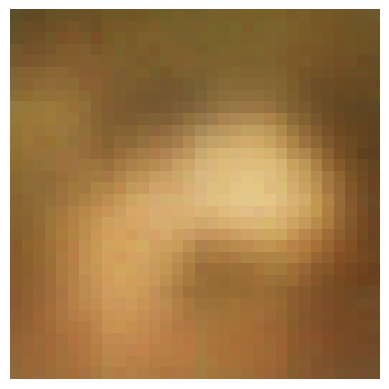

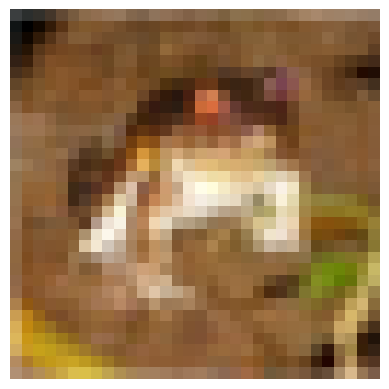

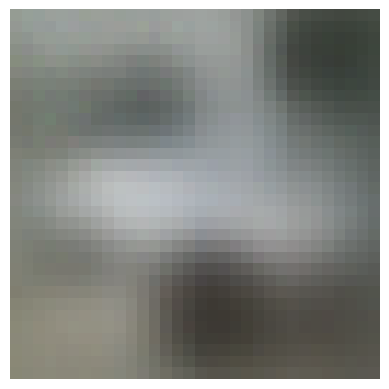

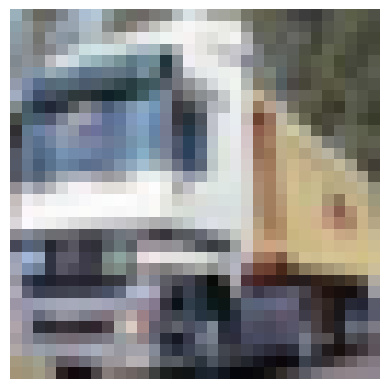

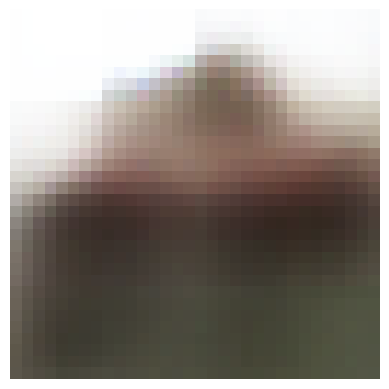

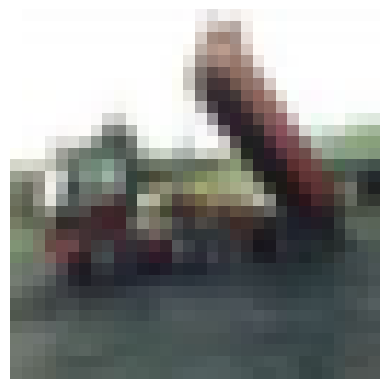

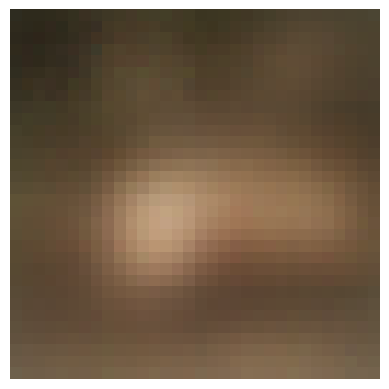

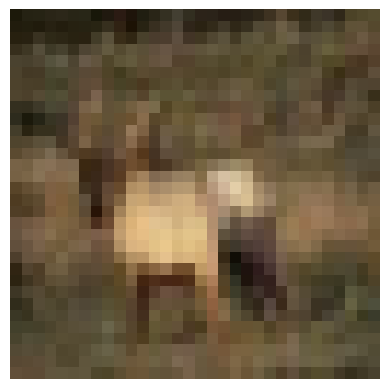

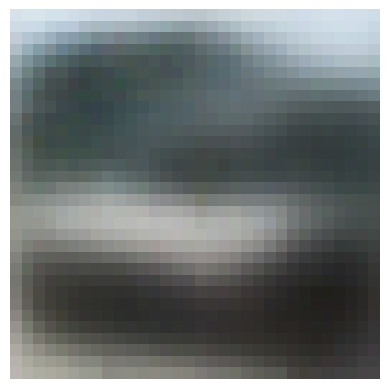

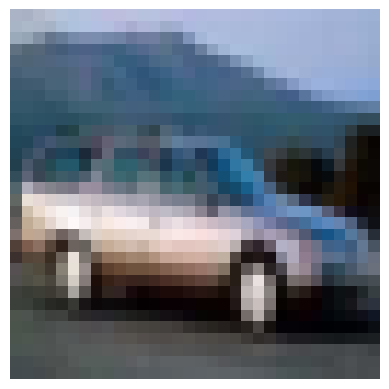

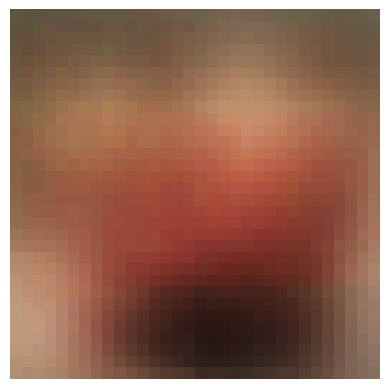

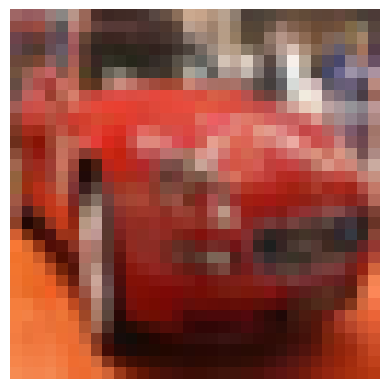

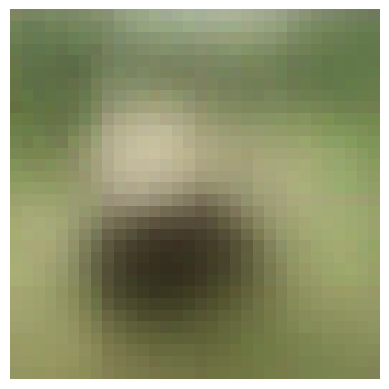

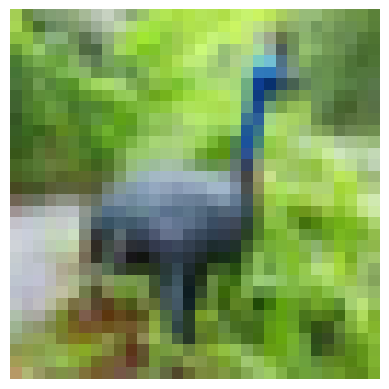

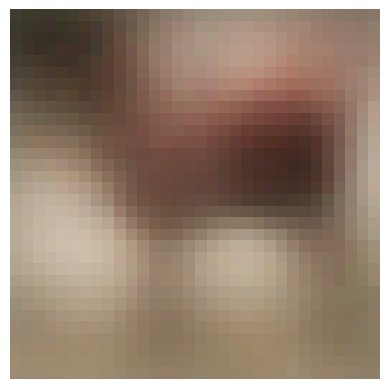

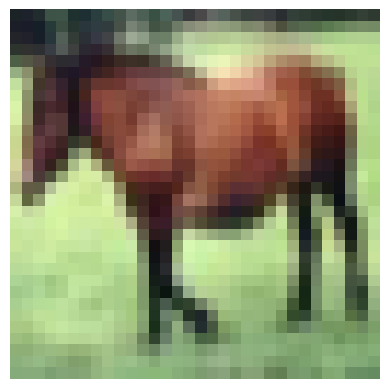

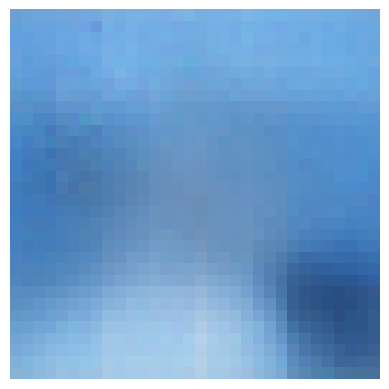

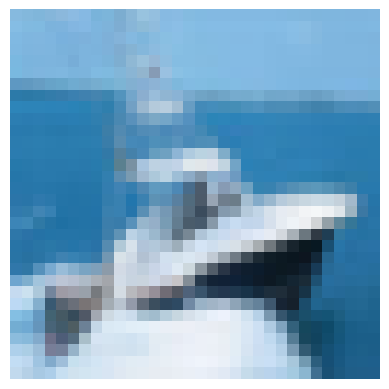

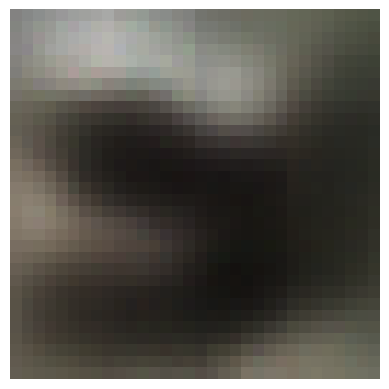

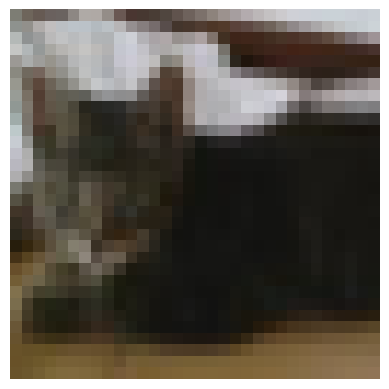

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def show_torch_image(img):
    img = img.permute(1, 2, 0)
    img = img.numpy().astype(np.uint8)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

for i in range(10):
    sample_output, z_e, z_quantized = model(x_train[i].unsqueeze(0))
    show_torch_image(255*sample_output.squeeze(0).detach().cpu())
    show_torch_image(255 * x_train[i].cpu())